In [1]:
import sys
print(sys.version, sys.platform, sys.executable)

3.7.6 (default, Aug  9 2020, 21:13:30) 
[Clang 11.0.3 (clang-1103.0.32.62)] darwin /Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/bin/python3.7


In [2]:
import os
os.chdir('/Users/layne/Desktop/pydatasci')
os.getcwd()

'/Users/layne/Desktop/pydatasci'

In [3]:
import h5py
import pydatasci as pds
from pydatasci import aidb
import os, sqlite3, io, gzip 
import pandas as pd
import numpy as np
import pyarrow
from pyarrow import csv as pc

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.callbacks import History
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import plotly.express as px

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
from importlib import reload; aidb.delete_db(True); reload(aidb); aidb.create_db()


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created database file for machine learning metrics at path:
/Users/layne/Library/Application Support/pydatasci/aidb.sqlite3


=> Success - created the following tables within database:
['algorithm', 'batch', 'dataset', 'featureset', 'fold', 'foldset', 'hyperparamcombo', 'hyperparamset', 'job', 'label', 'preprocess', 'result', 'splitset']



---

In [5]:
dataset = aidb.Dataset.from_file(
	path = 'data/iris.tsv' 
	,file_format = 'tsv'
	,name = 'tab-separated plants'
	,perform_gzip = True
    ,dtype = 'float64'
)

In [6]:
label_name = 'target'

In [7]:
label = dataset.make_label(columns=[label_name])

In [8]:
featureset = dataset.make_featureset(exclude_columns=[label_name])

In [9]:
splitset = featureset.make_splitset(
	label_id = label.id
	, size_test = 0.20
	, size_validation = 0.12
)

In [10]:
#foldset = splitset.make_foldset(fold_count=6)

# aidb

### Define Preprocess (Optional)

Going to have to make sure that I am uniformly importing the packages. 
`from sklearn.preprocessing import *`

In [11]:
encoder_features = StandardScaler()

In [12]:
encoder_labels = OneHotEncoder(sparse=False)

In [13]:
#params_encode_labels = {"sparse": [False]}

### Define Algorithm

In [14]:
def function_model_build(**hyperparameters):
    model = Sequential()
    model.add(Dense(13, input_shape=(4,), activation='relu', kernel_initializer='he_uniform', name='fc1')) # first hidden layer
    model.add(Dropout(0.2))
    model.add(Dense(hyperparameters['l2_neuron_count'], activation='relu', kernel_initializer='he_uniform', name='fc2'))
    model.add(Dense(3, activation='softmax', name='output'))

    model.compile(optimizer=hyperparameters['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):
    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = 3
        , epochs = hyperparameters['epochs']
        , callbacks=[History()]
    )
    return model

In [16]:
def function_model_evaluate(model, samples_evaluate, **hyperparameters):
    scores = model.evaluate(samples_evaluate["features"], samples_evaluate["labels"], verbose=0)
    #print("Loss = " + str(results[0]) + " // Accuracy = " + str(results[1]) )
    return scores

In [17]:
def function_model_predict(model, samples_predict, **hyperparameters):
    probabilities = model.predict(samples_predict['features'])
    # performance metrics will not work in OHE format.
    predictions = np.argmax(probabilities, axis=-1)
    
    return predictions, probabilities

In [18]:
hyperparameters = {
    "l2_neuron_count": [9, 13, 18]
    , "optimizer": ["adamax", "adam"]
    , "epochs": [66]
}

### Stage the Experiment and Parameters

In [19]:
algorithm = aidb.Algorithm.create(
    library = "Keras"
    , description = "dense, 2 layers, medium height"
	, function_model_build = function_model_build
	, function_model_train = function_model_train
	, function_model_evaluate = function_model_evaluate
    , function_model_predict = function_model_predict
)

In [20]:
preprocess = aidb.Preprocess.from_splitset(
    splitset_id = splitset.id
    , description = "standard scaling on features"
    , encoder_features = encoder_features
    , encoder_labels = encoder_labels
)

In [21]:
hyperparamset = aidb.Hyperparamset.from_algorithm(
    algorithm_id = algorithm.id
    , preprocess_id = preprocess.id
    , description = "experimenting with number of epochs"
	, hyperparameters = hyperparameters
)

In [22]:
hyperparamset.hyperparamcombo_count

6

In [23]:
batch = aidb.Batch.from_algorithm(
    algorithm_id = algorithm.id
    , splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , foldset_id = None #foldset.id
    , only_folded_training = False
)

In [24]:
batch.job_count

6

In [25]:
batch.get_statuses()

{1: 'Not yet started',
 2: 'Not yet started',
 3: 'Not yet started',
 4: 'Not yet started',
 5: 'Not yet started',
 6: 'Not yet started'}

In [26]:
#batch.stop_jobs()

In [27]:
#batch.jobs[0].results[0].get_model()
#batch.jobs[0].results[0].evaluations
#batch.jobs[0].results[0].model_history
#batch.jobs[0].results[0].predictions
#batch.jobs[0].results[0].confusion_matrices

In [28]:
batch.run_jobs(verbose=False)

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 6/6 [00:20<00:00,  3.36s/it]


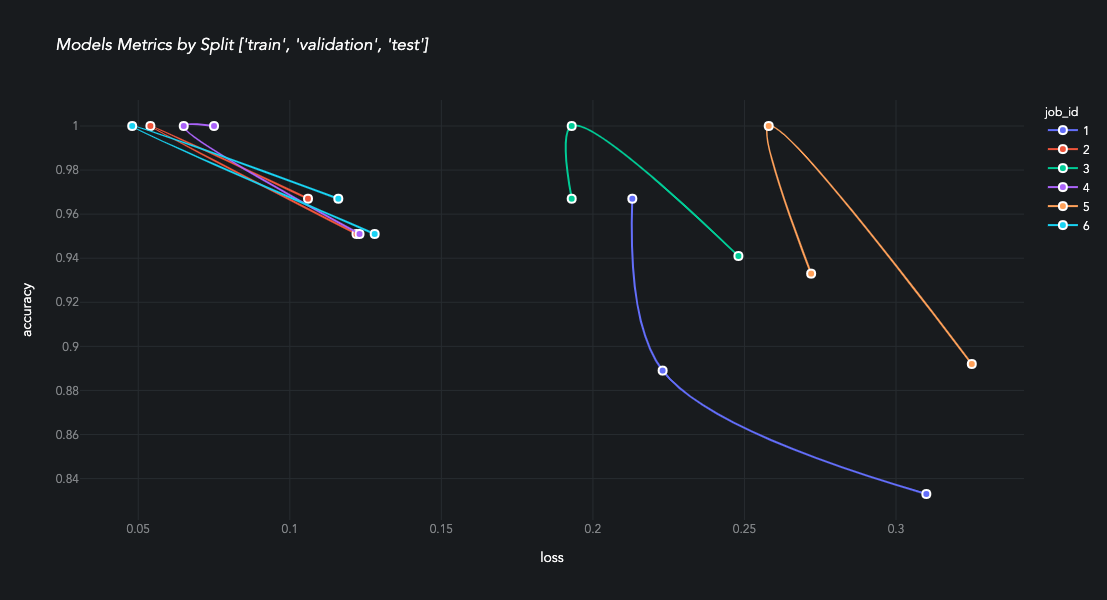

In [31]:
batch.plot_evaluations(max_loss=0.35, min_accuracy=0.80)

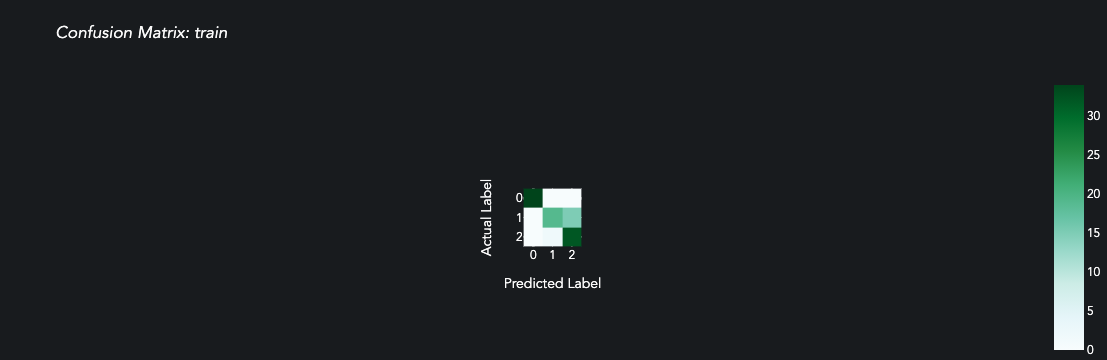

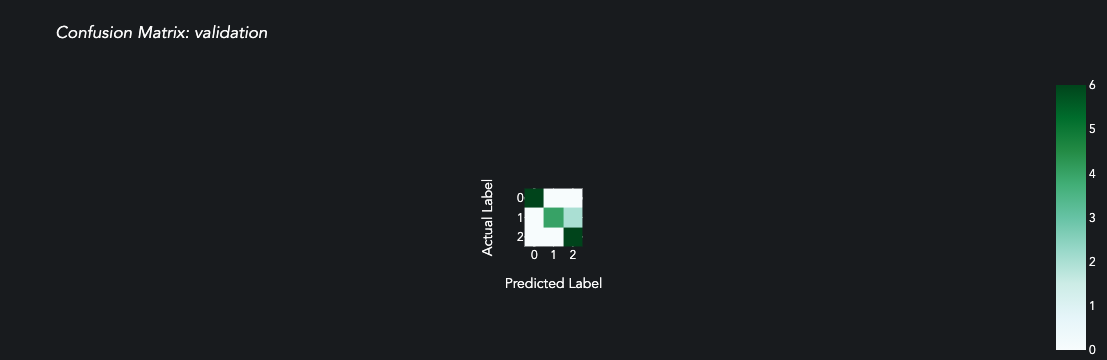

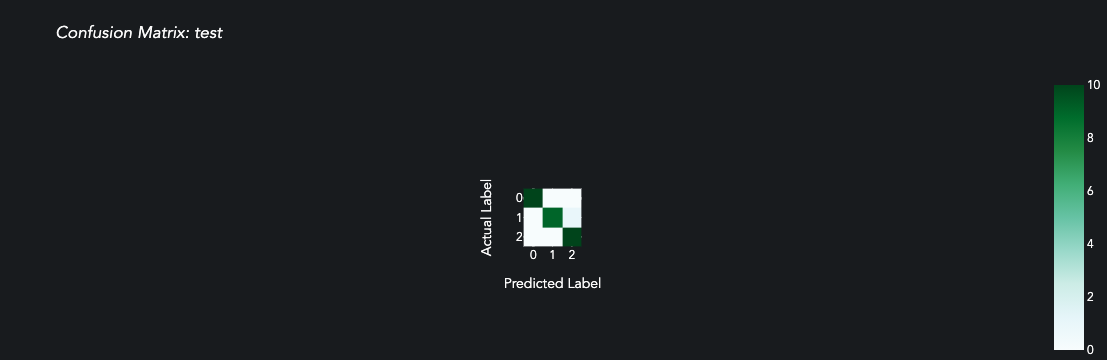

In [30]:
batch.jobs[0].results[0].plot_confusion_matrices()

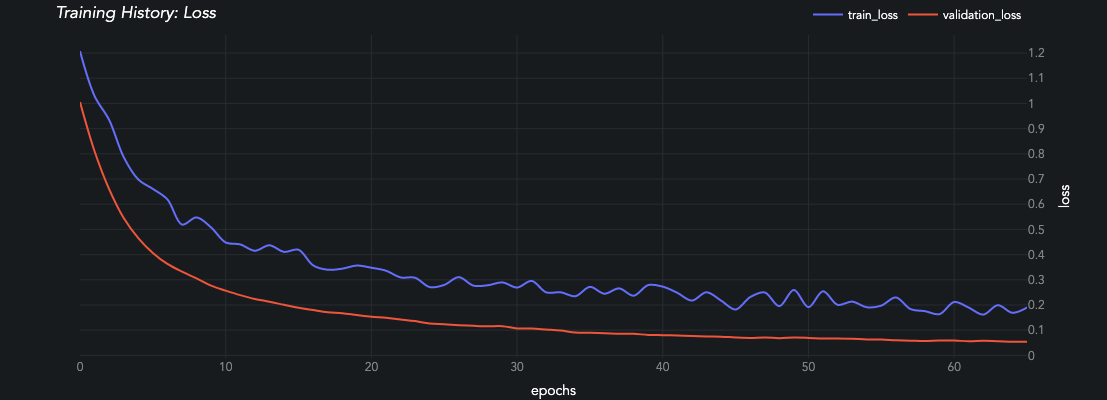

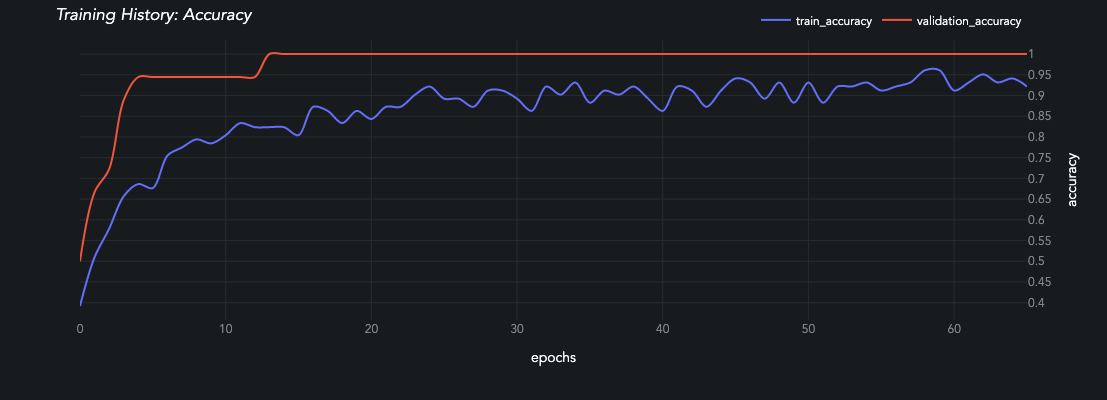

In [32]:
batch.jobs[1].results[0].plot_history()

---

---

---

In [32]:
history = batch.jobs[0].results[0].model_history

In [33]:
history

{'loss': [1.4876127243041992,
  1.41118586063385,
  1.3021676540374756,
  1.3235801458358765,
  1.160387635231018,
  1.1585201025009155,
  1.2262650728225708,
  1.0738797187805176,
  1.1370903253555298,
  1.1054381132125854,
  1.0766690969467163,
  1.0019382238388062,
  0.9757674932479858,
  0.9733763337135315,
  0.9068111181259155,
  0.9635732173919678,
  0.9205518364906311,
  0.9566658139228821,
  0.903951108455658,
  0.9302955269813538,
  0.9192895293235779,
  0.8332658410072327,
  0.8293278217315674,
  0.8435032963752747,
  0.8233342170715332,
  0.7704917788505554,
  0.763940155506134,
  0.8148898482322693,
  0.6971704363822937,
  0.7083523273468018,
  0.7872446775436401,
  0.7314227223396301,
  0.6794066429138184,
  0.6781052350997925,
  0.6744627356529236,
  0.6214244365692139,
  0.672360897064209,
  0.6034711003303528,
  0.609622061252594,
  0.565484344959259,
  0.5453439354896545,
  0.566413402557373,
  0.5220624804496765,
  0.5550760626792908,
  0.5340074300765991,
  0.5257921

In [34]:
df = pd.DataFrame.from_dict(history, orient='index').transpose()

In [35]:
df_loss = df[['loss','val_loss']]
df_loss = df_loss.rename(columns={"loss": "train_loss", "val_loss": "validation_loss"})

In [36]:
df_acc = df[['accuracy', 'val_accuracy']]
df_acc = df_acc.rename(columns={"accuracy": "train_accuracy", "val_accuracy": "validation_accuracy"})

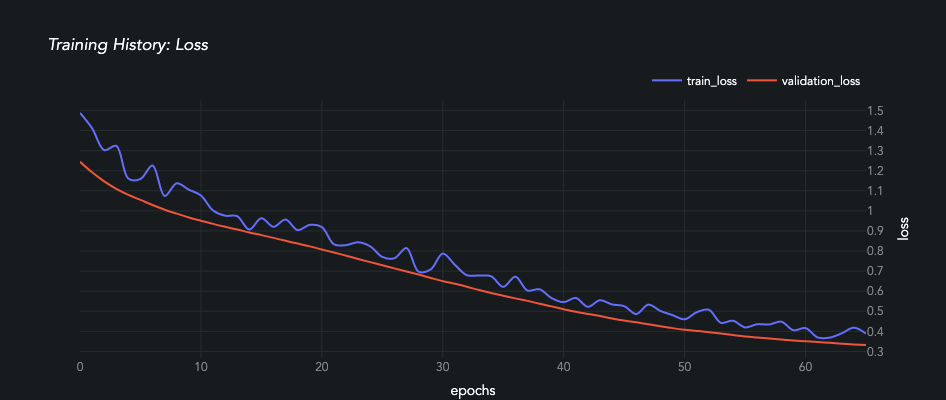

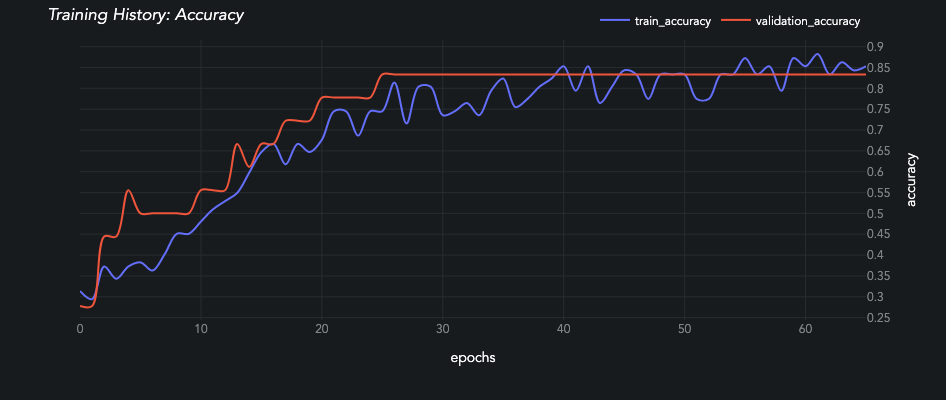

In [38]:
fig_loss = px.line(
    df_loss
    , title = '<i>Training History: Loss</i>'
    , line_shape = 'spline'
)
fig_loss.update_layout(
    xaxis_title = "epochs"
    , yaxis_title = "loss"
    , legend_title = None
    , font_family = "Avenir"
    , font_color = "#FAFAFA"
    , plot_bgcolor = "#181B1E"
    , paper_bgcolor = "#181B1E"
    , height = 400
    , hoverlabel = dict(
        bgcolor = "#0F0F0F"
        , font_size = 15
        , font_family = "Avenir"
    )
    , yaxis = dict(
        side = "right"
        , tickmode = 'linear'
        , tick0 = 0.0
        , dtick = 0.1
    )
    , legend = dict(
        orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="right"
        , x=1
    )
    , margin = dict(
        b = 0
    ),
)
fig_loss.update_xaxes(zeroline=False, gridcolor='#262B2F', tickfont=dict(color='#818487'))
fig_loss.update_yaxes(zeroline=False, gridcolor='#262B2F', tickfont=dict(color='#818487'))

fig_acc = px.line(
    df_acc
    , title = '<i>Training History: Accuracy</i>'
    , line_shape = 'spline'
)
fig_acc.update_layout(
    xaxis_title = "epochs"
    , yaxis_title = "accuracy"
    , legend_title = None
    , font_family = "Avenir"
    , font_color = "#FAFAFA"
    , plot_bgcolor = "#181B1E"
    , paper_bgcolor = "#181B1E"
    , height = 400
    , hoverlabel = dict(
        bgcolor = "#0F0F0F"
        , font_size = 15
        , font_family = "Avenir"
    )
    , yaxis = dict(
        side = "right"
        , tickmode = 'linear'
        , tick0 = 0.0
        , dtick = 0.05
    )
    , legend = dict(
        orientation="h"
        , yanchor="bottom"
        , y=1.02
        , xanchor="right"
        , x=1
    )
    , margin = dict(
        t = 5
    ),
)
fig_acc.update_xaxes(zeroline=False, gridcolor='#262B2F', tickfont=dict(color='#818487'))
fig_acc.update_yaxes(zeroline=False, gridcolor='#262B2F', tickfont=dict(color='#818487'))

fig_loss.show()
fig_acc.show()

---

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

In [149]:
cms = batch.jobs[0].results[0].confusion_matrices.items()

In [150]:
cms

dict_items([('train', array([[34,  0,  0],
       [ 2, 18, 14],
       [ 0,  1, 33]])), ('validation', array([[6, 0, 0],
       [0, 2, 4],
       [0, 0, 6]])), ('test', array([[10,  0,  0],
       [ 2,  5,  3],
       [ 0,  0, 10]]))])

In [40]:
cm = batch.jobs[0].results[0].confusion_matrices['test']

In [148]:
fig = px.imshow(
    cm
    , title = '<i>Confusion Matrices</i>'
    , color_continuous_scale = px.colors.sequential.Cividis_r
    , labels=dict(
        x = "Predicted Label"
        , y = "Actual Label"
    )
)
fig.update_layout(
    xaxis_title = "Predicted Label"
    , yaxis_title = "Actual Label"
    , legend_title = 'Sample Count'
    , font_family = "Avenir"
    , font_color = "#FAFAFA"
    , plot_bgcolor = "#181B1E"
    , paper_bgcolor = "#181B1E"
    , height = 200
    , hoverlabel = dict(
        bgcolor = "#0F0F0F"
        , font_size = 15
        , font_family = "Avenir"
    )
    , yaxis = dict(
        tickmode = 'linear'
        , tick0 = 0.0
        , dtick = 1.0
    )
    , title = dict(
        text = "Plot Title"
        , y = 0.85
        , x = 0.5
        , xanchor = 'center'
        , yanchor = 'top'
    )
)
figs.append(fig)

NameError: name 'figs' is not defined

In [147]:
for f in figs:
    f.show()

NameError: name 'figs' is not defined

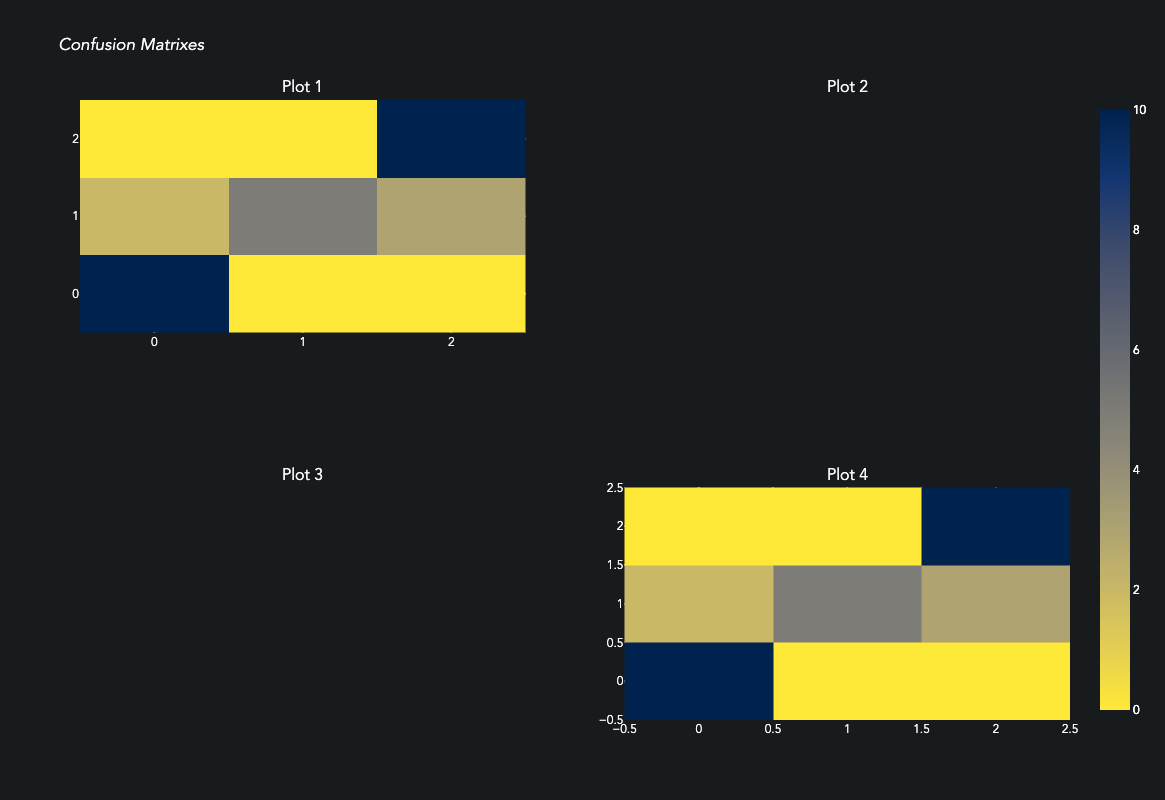

In [96]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4",))
fig.add_trace(
    go.Heatmap(z=cm, colorscale='Cividis_r'),
    row=1, col=1
)
fig.add_trace(
    go.Heatmap(z=cm, colorscale='Cividis_r'),
    row=2, col=2
)
fig.update_layout(
    title = "<i>Confusion Matrixes</i>"
    , font_family = "Avenir"
    , font_color = "#FAFAFA"
    , plot_bgcolor = "#181B1E"
    , paper_bgcolor = "#181B1E"
    , height = 800
    , hoverlabel = dict(
        bgcolor = "#0F0F0F"
        , font_size = 15
        , font_family = "Avenir"
    )
    , yaxis = dict(
        tickmode = 'linear'
        , tick0 = 0.0
        , dtick = 1.0
    )
    , xaxis = dict(
        tickmode = 'linear'
        , tick0 = 0.0
        , dtick = 1.0
    )
)
#fig.show()

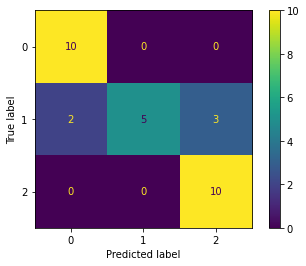

In [38]:
px.imshow(batch.jobs[0].results[0].confusion_matrices['test'])

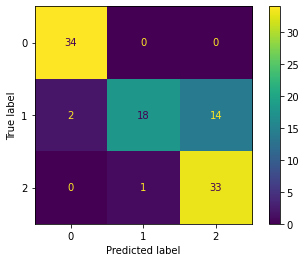

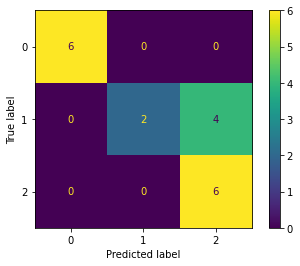

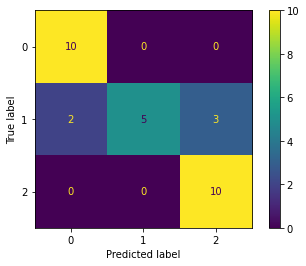

In [42]:
for k,v in cms:
    ConfusionMatrixDisplay(v).plot()

---

In [30]:
evaluation_dicts = aidb.Result.select(
    aidb.Result.id, aidb.Result.evaluations
).join(aidb.Job).join(aidb.Batch).where(aidb.Batch.id == 1).dicts()

In [31]:
data_names = list(evaluation_dicts[0]['evaluations'].keys())

In [32]:
# for d in evaluation_dicts:
#     for k in data_names:
#         key_loss = k + '_loss'
#         key_acc = k + '_accuracy'
        
#         d[key_loss] = d['evaluations'][k][0]
#         d[key_acc] = d['evaluations'][k][1]
    
#     del d['evaluations']

In [33]:
max_loss = 0.3
min_acc = 0.85

In [34]:
# need to extract each instance from the model object
evaluation_dicts = [ed for ed in evaluation_dicts]

In [35]:
dicts_by_split = []

# Create a separate dictionary for each split.
# Prune out the jobs that don't meet the criteria for any split.
for d in evaluation_dicts:
    rows = []
    checks = []
    for k in data_names:
        pack = {}
        loss = d['evaluations'][k][0]
        loss = round(loss, 3)
        acc = d['evaluations'][k][1]
        acc = round(acc, 3)
        
        if (loss >= max_loss) or (acc <= min_acc):
            failed = True
        else:
            failed = False
            pack['loss'] = loss
            pack['accuracy'] = acc
            # Manipulate so that `split` is it's own column is easy to plot.
            pack['split'] = k
            # Rename key to be obvious to user on the chart.
            pack['job_id'] = d['id']
            
        checks.append(failed)
        rows.append(pack)
    if True in checks:
        pass
    else:
        for r in rows:
            dicts_by_split.append(r)

In [36]:
df = pd.DataFrame.from_records(dicts_by_split)
df

,loss,accuracy,split,job_id
0,0.166,0.941,train,2
1,0.261,0.889,validation,2
2,0.212,0.900,test,2
3,0.125,0.961,train,4
4,0.222,0.944,validation,4
5,0.242,0.967,test,4
6,0.101,0.951,train,6
7,0.138,0.944,validation,6
8,0.067,1.000,test,6


In [37]:
# fig = px.scatter(
#     df
#     , title = 'Models by Loss and Accuracy'
#     , x = 'validation_loss'
#     , y = 'validation_accuracy'
#     , text = 'id'
#     , color = 'validation_accuracy'
#     #, size = 'validation_loss'
#     , color_continuous_scale=px.colors.sequential.Mint
#     , opacity=0.65
#     , height = 750
# )
# fig.update_traces(textposition='top center', marker = dict(size=10))
# fig.show()

In [38]:
# import pandas as pd
# df = pd.DataFrame.from_records([
#     {'job_id': '1', 'split': 'train', 'loss': 0.05, 'accuracy': 0.95}
#     , {'job_id': '1', 'split': 'validation', 'loss': 0.04, 'accuracy': 0.96}
#     , {'job_id': '1', 'split': 'test', 'loss': 0.03, 'accuracy': 0.97}
#     , {'job_id': '2', 'split': 'train', 'loss': 0.15, 'accuracy': 0.85}
#     , {'job_id': '2', 'split': 'validation', 'loss': 0.14, 'accuracy': 0.86}
#     , {'job_id': '2', 'split': 'test', 'loss': 0.13, 'accuracy': 0.87}
# ])

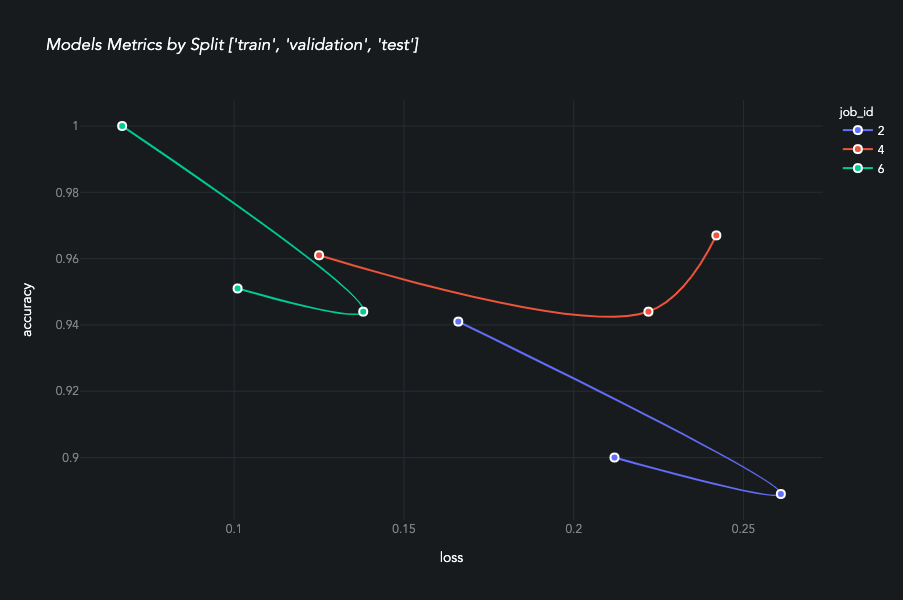

In [41]:
fig = px.line(
    df
    , title = '<i>Models Metrics by Split ' + str(data_names) + '</i>'
    , x = 'loss'
    , y = 'accuracy'
    , text = 'split'
    , color = 'job_id'
    , height = 600
    , hover_data = ['job_id', 'split', 'accuracy', 'loss']
    , line_shape='spline'
)
fig.update_traces(
    mode = 'markers+lines'
    , textposition = 'top center'
    , line = dict(width=2)
    , marker = dict(
        size = 8,
        line = dict(
            width = 2,
            color = 'white'
        )
    )
)
fig.update_layout(
    font_family = "Avenir"
    , font_color = "#FAFAFA"
    , plot_bgcolor = "#181B1E"
    , paper_bgcolor = "#181B1E"
    , hoverlabel = dict(
        bgcolor = "#0F0F0F"
        , font_size = 15
        , font_family = "Avenir"
    )
)
fig.update_xaxes(gridcolor='#262B2F', tickfont=dict(color='#818487'))
fig.update_yaxes(gridcolor='#262B2F', tickfont=dict(color='#818487'))
# include the 'split' in the hover
fig

---

---

---

### Data to use

In [52]:
samples = splitset.to_numpy()

In [53]:
train_features = samples["train"]["features"]
validation_features = samples["validation"]["features"]
test_features = samples["test"]["features"]

In [54]:
train_labels = samples["train"]["labels"]
validation_labels = samples["validation"]["labels"]
test_labels = samples["test"]["labels"]

In [55]:
train_labels

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [2.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [2.],
       [0.],
       [0.],
       [1.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [2.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [0.],
       [0.],
       [2.],
       [1.],
       [0.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [0.],
       [0.],
       [2.],
       [2.],
       [0.],
       [1.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [0.],
       [1.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [0.],

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

---

^ Alternatively, pass in a dictionary of values for that keyword.

^ Or just pass the params directly into the encoder function if you don't want to hypertune on them.

In [ ]:
encoder_labels = encoder.set_params(**encode_features_kwargs)

In [ ]:
encoder_labels_trained = encoder_labels.fit(train_labels)

In [ ]:
train_labels = encoder_labels_trained.transform(train_labels)
validation_labels = encoder_labels_trained.transform(validation_labels)
test_labels = encoder_labels_trained.transform(test_labels)

Create the preprocess object.

In [ ]:
preprocess = aidb.Preprocess.create(
    encode_labels_function = encoder
)

In [ ]:
feature_encoder = preprocess.preprocess_labels_function.set_params(**preprocess_features_kwargs)

In [ ]:
encoder_labels_trained = feature_encoder.fit(train_labels)

In [ ]:
train_labels = encoder_labels_trained.transform(train_labels)
validation_labels = encoder_labels_trained.transform(validation_labels)
test_labels = encoder_labels_trained.transform(test_labels)

^^^ Now do the same, but with kwargs stored in the hyperparamset attribute.

---

---

# Normal

ToDo - Does Pandas labels probably wants a series too, not a full dataframe? `.as_series()` method?

In [58]:
samples = splitset.to_numpy()

In [59]:
train_features = samples["train"]["features"]
test_features = samples["test"]["features"]

In [60]:
train_labels = samples["train"]["labels"]
test_labels = samples["test"]["labels"]

In [61]:
encoder = OneHotEncoder(sparse=False)
train_labels = encoder.fit_transform(train_labels)
test_labels = encoder.fit_transform(test_labels)

In [62]:
model = Sequential()
model.add(Dense(13, input_shape=(4,), activation='relu', kernel_initializer='he_uniform', name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(13, activation='relu', kernel_initializer='he_uniform', name='fc2'))
model.add(Dense(3, activation='softmax', name='output'))
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 13)                65        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
fc2 (Dense)                  (None, 13)                182       
_________________________________________________________________
output (Dense)               (None, 3)                 42        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
# Train
history = model.fit(
    train_features
    , train_labels
    , validation_data = (test_features, test_labels)
    , verbose = 0
    , batch_size = 6
    , epochs = 60
    , callbacks=[History()]
)

In [65]:
model.predict(test_features)

array([[0.03070234, 0.5700312 , 0.39926645],
       [0.00822134, 0.22307324, 0.7687054 ],
       [0.7288933 , 0.13709158, 0.13401519],
       [0.01583868, 0.37963992, 0.60452133],
       [0.01494808, 0.19663215, 0.7884198 ],
       [0.03527968, 0.45334923, 0.5113711 ],
       [0.04365011, 0.6492737 , 0.3070762 ],
       [0.04234547, 0.60587937, 0.35177517],
       [0.7022052 , 0.15257053, 0.14522418],
       [0.72239184, 0.13987067, 0.13773742],
       [0.00887895, 0.22581851, 0.76530254],
       [0.0115312 , 0.46477753, 0.52369124],
       [0.01872727, 0.6345381 , 0.34673455],
       [0.01095912, 0.314755  , 0.6742859 ],
       [0.720332  , 0.14074783, 0.13892019],
       [0.04369351, 0.47972244, 0.47658408],
       [0.7320977 , 0.13571581, 0.1321865 ],
       [0.70678467, 0.14647636, 0.14673899],
       [0.69232464, 0.15251435, 0.15516105],
       [0.04425205, 0.5984452 , 0.3573028 ],
       [0.71748024, 0.1419595 , 0.1405603 ],
       [0.0183403 , 0.25982895, 0.7218307 ],
       [0.